# Stock Options Processing

This notebook is intended to clean and process the data from B3.

In [8]:
# @title Configuration

import glob
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import math
from typing import List, Dict, Optional, Callable
from functools import partial
from tqdm.notebook import tqdm
from google.colab import drive

##### Configutation #####
drive.mount("/content/drive/")
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
sns.set_palette("mako")
tqdm.pandas()

##### Constants #####

## Tickers ##
PETR4_TICKER = "PETR4"
VALE3_TICKER = "VALE3"
ITUB4_TICKER = "ITUB4"
BBAS3_TICKER = "BBAS3"
ABEV3_TICKER = "ABEV3"
B3SA3_TICKER = "B3SA3"
BBDC4_TICKER = "BBDC4"
BOVA11_TICKER = "BOVA11"

## Data ##
DATA_FOLDER_PATH = "/content/drive/MyDrive/UFC/TCC_STOCK_OPTIONS/stock-options/data/"
DATA_PATH = DATA_FOLDER_PATH + "COTAHIST_A*.TXT"
TICKER_PATTERN = "".join([f"({ticker})|" for ticker in [
    "PETR", # PETR4, Petrobras
    "VALE", # VALE3, Vale
    "ITUB", # ITUB4, Itaú
    "BBAS", # BBAS3, Banco do Brasil
    "ABEV", # ABEV3, Ambev
    "B3SA", # B3SA3, B3
    "BBDC", # BBDC4, Bradesco
    "BOV", # BOVA11, IBovespa
]])[:-1]
# Market types for the column 'tipo_mercado'
STOCK_COD, CALL_COD, PUT_COD = 10, 70, 80
FIELD_WIDTHS = [
    2, 8, 2, 12, 3, 12, 10, 3, 4, 13, 13, 13, 13,
    13, 13, 13, 5, 18, 18, 13, 1, 8, 7, 13, 12, 3
]
COLUMNS = [
    "tipo_registro", "data_pregao", "cod_bdi", "cod_negociacao", "tipo_mercado",
    "nome_empresa", "especificacao_papel", "prazo_dias_merc_termo", "moeda_referencia",
    "preco_abertura", "preco_maximo", "preco_minimo", "preco_medio", "preco_ultimo_negocio",
    "preco_melhor_oferta_compra", "preco_melhor_oferta_venda", "numero_negocios",
    "quantidade_papeis_negociados", "volume_total_negociado", "preco_exercicio",
    "ìndicador_correcao_precos", "data_vencimento" , "fator_cotacao",
    "preco_exercicio_pontos", "codigo_isin", "num_distribuicao_papel"
]
USEFUL_COLUMNS = [
    "data_pregao",
    "cod_negociacao", # E.g. PETR4, VALE3
    "especificacao_papel",
    "tipo_mercado",
    "preco_ultimo_negocio",
    "preco_maximo",
    "volume_total_negociado",
    "preco_exercicio",
    "data_vencimento",
]
USEFUL_NUMERICAL_COLUMNS = [
    "preco_ultimo_negocio",
    "preco_maximo",
    "volume_total_negociado",
    "preco_exercicio",
]
USEFUL_DATE_COLUMNS = ["data_pregao", "data_vencimento"]

Mounted at /content/drive/


## Prepare the Data

In this section, we'll prepare the data provided by B3 for stocks, calls and puts taking into account the impact of dividends. Then, we'll register the data so we don't have to go through this process again.

In [9]:
# @title Load raw data

# @markdown Read files that hold the name pattern: 'DATA_PATH'. The files are supposed to be formatted as described in ./data/SeriesHistoricas_Layout.pdf

class B3FilesFoundNotFound(Exception):
    pass

files: List[str] = glob.glob(DATA_PATH)
if len(files) == 0: raise B3FilesFoundNotFound()

assets_df = pd.DataFrame()
for f in files:
    temp_df = pd.read_fwf(
        f,
        widths=FIELD_WIDTHS,
        names=COLUMNS,
        dtype={"data_pregao": np.int64, "data_vencimento": np.int64},
        header=None,
        # The first and the last rows contain metadata, so we drop them
        skiprows=1,
        skipfooter=1,
    )[USEFUL_COLUMNS]
    temp_df = temp_df[
        (temp_df["cod_negociacao"].str.match(TICKER_PATTERN))
        & (temp_df["tipo_mercado"].isin([STOCK_COD, CALL_COD, PUT_COD]))
    ]
    
    assets_df = assets_df.append(temp_df)

assets_df.reset_index(drop=True, inplace=True)
# Divide all numerical columns by 100 to get the right decimal value
assets_df[USEFUL_NUMERICAL_COLUMNS] = assets_df[USEFUL_NUMERICAL_COLUMNS].div(100)

del temp_df

# Save data
assets_df.to_csv(DATA_FOLDER_PATH + "assets.csv", index=False)

In [10]:
assets_df = pd.read_csv(DATA_FOLDER_PATH + "assets.csv")

assets_df.sample(3)

,data_pregao,cod_negociacao,especificacao_papel,tipo_mercado,preco_ultimo_negocio,preco_maximo,volume_total_negociado,preco_exercicio,data_vencimento
959677,20210324,VALED120,ON NM,70,0.09,0.10,5538.00,116.10,20210419
873884,20210602,BOVAT115,CI,80,1.84,1.87,935.62,115.00,20210820
643654,20200818,PETRI192,PN N2,70,3.97,4.01,84962.00,19.28,20200921


### Datasets

Here, we'll create datasets to analyse the stocks and options for two companies which are Petrobrás and Vale

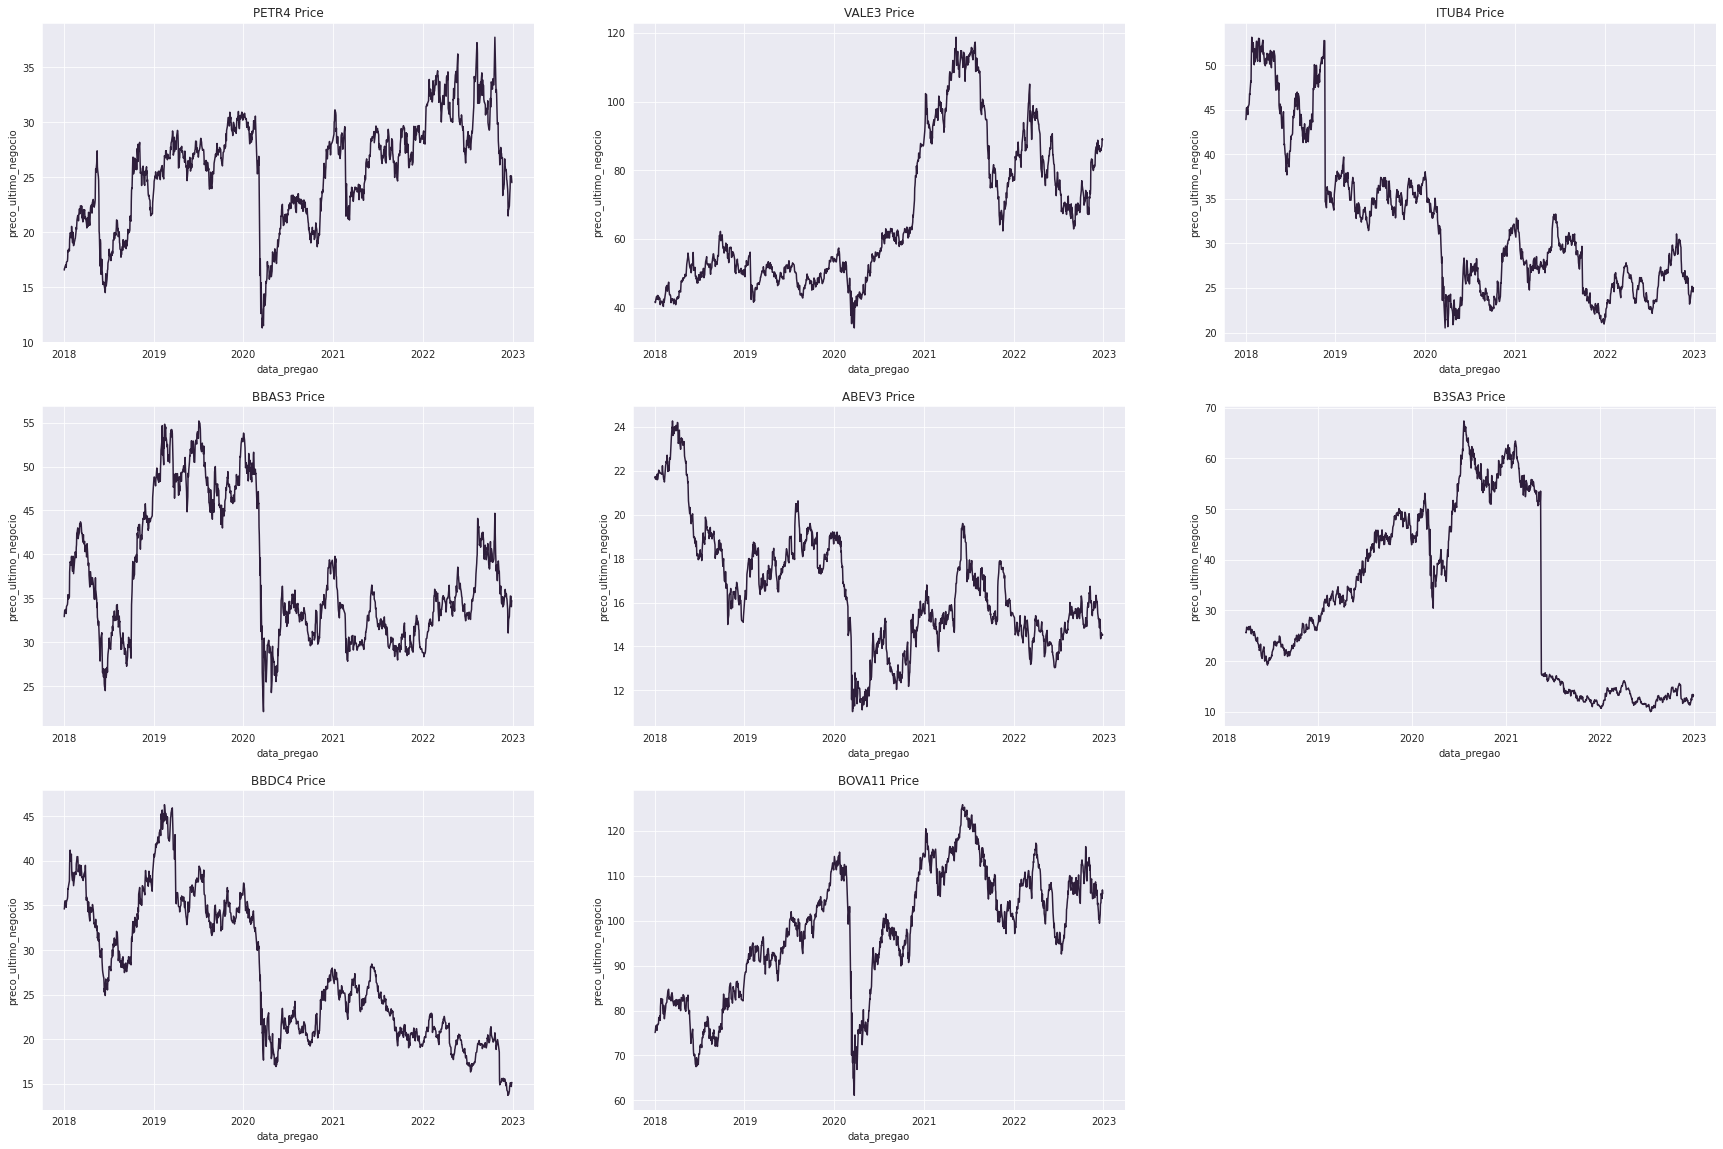

In [11]:
# @title Stocks
# @markdown Load and plot stocks

def get_raw_stock_df(ticker: str, assest_df: pd.DataFrame) -> pd.DataFrame:
    stock_df_ = assets_df[
        (assets_df["cod_negociacao"] == ticker)
        & (assets_df["tipo_mercado"] == STOCK_COD)
    ].sort_values("data_pregao").reset_index(drop=True)
    stock_df_["data_pregao"] = pd.to_datetime(stock_df_["data_pregao"], format="%Y%m%d")
    return stock_df_

petr4_stock_df_ = get_raw_stock_df(PETR4_TICKER, assets_df)
vale3_stock_df_ = get_raw_stock_df(VALE3_TICKER, assets_df)
itub4_stock_df_ = get_raw_stock_df(ITUB4_TICKER, assets_df)
bbas3_stock_df_ = get_raw_stock_df(BBAS3_TICKER, assets_df)
abev3_stock_df_ = get_raw_stock_df(ABEV3_TICKER, assets_df)
b3sa3_stock_df_ = get_raw_stock_df(B3SA3_TICKER, assets_df)
bbdc4_stock_df_ = get_raw_stock_df(BBDC4_TICKER, assets_df)
bova11_stock_df = get_raw_stock_df(BOVA11_TICKER, assets_df)

### Plot Graphs ###
plt.figure(figsize=(30,20))

plt.subplot(3,3,1)
sns.lineplot(data=petr4_stock_df_, x="data_pregao", y="preco_ultimo_negocio")
_ = plt.title("PETR4 Price")

plt.subplot(3,3,2)
sns.lineplot(data=vale3_stock_df_, x="data_pregao", y="preco_ultimo_negocio")
_ = plt.title("VALE3 Price")

plt.subplot(3,3,3)
sns.lineplot(data=itub4_stock_df_, x="data_pregao", y="preco_ultimo_negocio")
_ = plt.title("ITUB4 Price")

plt.subplot(3,3,4)
sns.lineplot(data=bbas3_stock_df_, x="data_pregao", y="preco_ultimo_negocio")
_ = plt.title("BBAS3 Price")

plt.subplot(3,3,5)
sns.lineplot(data=abev3_stock_df_, x="data_pregao", y="preco_ultimo_negocio")
_ = plt.title("ABEV3 Price")

plt.subplot(3,3,6)
sns.lineplot(data=b3sa3_stock_df_, x="data_pregao", y="preco_ultimo_negocio")
_ = plt.title("B3SA3 Price")

plt.subplot(3,3,7)
sns.lineplot(data=bbdc4_stock_df_, x="data_pregao", y="preco_ultimo_negocio")
_ = plt.title("BBDC4 Price")

plt.subplot(3,3,8)
sns.lineplot(data=bova11_stock_df, x="data_pregao", y="preco_ultimo_negocio")
_ = plt.title("BOVA11 Price")

In [14]:
# @title Calls

# @markdown Load and plot call options

def get_raw_stock_df(ticker: str, assest_df: pd.DataFrame, stock_type: Optional[str] = None) -> pd.DataFrame:
    
    call_df_ = assets_df[
        (assets_df["cod_negociacao"].str.startswith(ticker))
        & (assets_df["tipo_mercado"] == CALL_COD)
    ].sort_values("data_pregao").reset_index(drop=True)
    if stock_type:
        call_df_ = call_df_[call_df_["especificacao_papel"].str.startswith(stock_type)]
    for date_col in USEFUL_DATE_COLUMNS:
        call_df_[date_col] = pd.to_datetime(call_df_[date_col], format="%Y%m%d")
    
    return call_df_

petr4_call_df_ = get_raw_stock_df("PETR", assets_df, "PN")
vale3_call_df_ = get_raw_stock_df("VALE", assets_df, "ON")
itub4_call_df_ = get_raw_stock_df("ITUB", assets_df, "PN")
bbas3_call_df_ = get_raw_stock_df("BBAS", assets_df, "ON")
abev3_call_df_ = get_raw_stock_df("ABEV", assets_df, "ON")
b3sa3_call_df_ = get_raw_stock_df("B3SA", assets_df, "ON")
bbdc4_call_df_ = get_raw_stock_df("BBDC", assets_df, "PN")
bova11_call_df = get_raw_stock_df("BOVA", assets_df, None)

## Share Splitting and Dividends

We need to verify how the payment of dividends impacts the data provided by B3.
Since some stocks doesn't pay dividends to theirs inverstor (e.g. BOVA11), we don't need to worry about them at this point.

At the ex-dividend dates, the dividends paid by the company are taken away from both stock price and strike price.

Let's verify graphically how the dividends impact the stock and strike prices

Strike price difference for PETRH374 from 2022-08-11 to 2022-08-12: -6.67 BRL
Strike price difference for VALEC922 from 2021-03-04 to 2021-03-05: -4.14 BRL


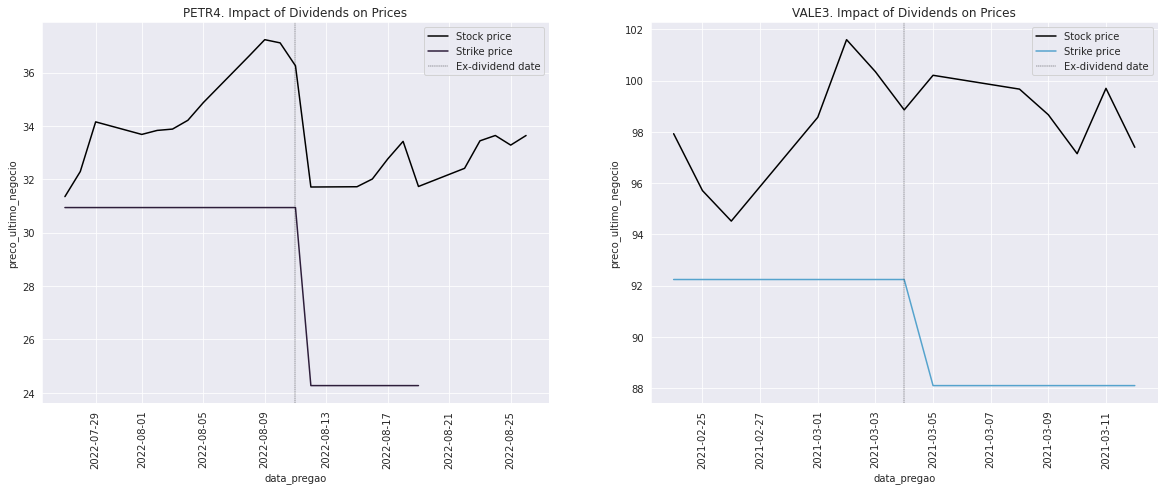

In [15]:
# @title Plot the impact of paying dividends

def plot_dividend_diff(
    stock_df: pd.DataFrame,
    call_df: pd.DataFrame,
    call_code: str,
    start_date: datetime,
    ex_dividend_date: datetime,
) -> None:
    # Make the time interval symmetic around the dividend payment date
    end_date = ex_dividend_date + (ex_dividend_date - start_date)

    stock_filtered_df = stock_df[
        stock_df["data_pregao"].between(start_date, end_date)
    ]
    call_filtered_df = call_df[
        call_df["data_pregao"].between(start_date, end_date)
        & (call_df["cod_negociacao"] == call_code)
    ]

    sns.set_palette("icefire")
    sns.set_style("darkgrid")
    # Plot the graph
    _ = sns.lineplot(
        data=stock_filtered_df,
        x="data_pregao",
        y="preco_ultimo_negocio",
        label="Stock price",
        color="k"
    )
    _ = sns.lineplot(
        data=call_filtered_df,
        x="data_pregao",
        y="preco_exercicio",
        label="Strike price"
    )
    plt.title("Impact of Dividends on Prices")
    plt.axvline(
        ex_dividend_date, 0, 40, linestyle='--',
        linewidth=0.35, color="k", label="Ex-dividend date"
    ) # type: ignore
    plt.legend()
    _ = plt.xticks(rotation="vertical")

    strike_price_diff = (
        call_filtered_df[call_filtered_df['data_pregao'] == ex_dividend_date + timedelta(days=1)]['preco_exercicio'].iloc[0]
        - call_filtered_df[call_filtered_df['data_pregao'] == ex_dividend_date]['preco_exercicio'].iloc[0]
    )
    print(f"Strike price difference for {call_code} from {ex_dividend_date.date()} to {ex_dividend_date.date() + timedelta(days=1)}: {strike_price_diff:.2f} BRL")

plt.figure(figsize=(20, 7))

plt.subplot(1,2,1)
plot_dividend_diff(
    stock_df=petr4_stock_df_,
    call_df=petr4_call_df_,
    call_code="PETRH374",
    start_date=datetime(year=2022, month=7, day=27),
    ex_dividend_date=datetime(year=2022, month=8, day=11),
)
plt.title("PETR4. Impact of Dividends on Prices")

plt.subplot(1,2,2)
plot_dividend_diff(
    stock_df=vale3_stock_df_,
    call_df=vale3_call_df_,
    call_code="VALEC922",
    start_date=datetime(year=2021, month=2, day=24),
    ex_dividend_date=datetime(year=2021, month=3, day=4),
)
_ = plt.title("VALE3. Impact of Dividends on Prices")

In [16]:
# @title Load Dividends

petr4_dividends_df = pd.read_csv(DATA_FOLDER_PATH + "dividends/petr4_dividends.csv")
vale3_dividends_df = pd.read_csv(DATA_FOLDER_PATH + "dividends/vale3_dividends.csv")
itub4_dividends_df = pd.read_csv(DATA_FOLDER_PATH + "dividends/itub4_dividends.csv")
bbas3_dividends_df = pd.read_csv(DATA_FOLDER_PATH + "dividends/bbas3_dividends.csv")
abev3_dividends_df = pd.read_csv(DATA_FOLDER_PATH + "dividends/abev3_dividends.csv")
b3sa3_dividends_df = pd.read_csv(DATA_FOLDER_PATH + "dividends/b3sa3_dividends.csv")
bbdc4_dividends_df = pd.read_csv(DATA_FOLDER_PATH + "dividends/bbdc4_dividends.csv")

for date_col in ["ex_date", "payment_date"]:
    petr4_dividends_df[date_col] = pd.to_datetime(petr4_dividends_df[date_col], format="%d/%m/%Y")
    vale3_dividends_df[date_col] = pd.to_datetime(vale3_dividends_df[date_col], format="%d/%m/%Y")
    itub4_dividends_df[date_col] = pd.to_datetime(itub4_dividends_df[date_col], format="%d/%m/%Y")
    bbas3_dividends_df[date_col] = pd.to_datetime(bbas3_dividends_df[date_col], format="%d/%m/%Y")
    abev3_dividends_df[date_col] = pd.to_datetime(abev3_dividends_df[date_col], format="%d/%m/%Y")
    b3sa3_dividends_df[date_col] = pd.to_datetime(b3sa3_dividends_df[date_col], format="%d/%m/%Y")
    bbdc4_dividends_df[date_col] = pd.to_datetime(bbdc4_dividends_df[date_col], format="%d/%m/%Y")

In [17]:
# @title Undo Share Splitting and Rectify Dividens

# @markdown As a first approach, we'll consider that the dividends have never been paid. To do so, we'll add the value of the dividends to both stock and strike prices from the ex-dividend dates onwards.

def rectify_dividends(
    df: pd.DataFrame,
    dividend_df: pd.DataFrame,
    price_column: str,
) -> pd.DataFrame:
    """
    Add the dividends to the price_column in df
    """

    rectified_df = df.copy()
    for _, dividend_row in dividend_df.iterrows():
      rectified_df[price_column] = rectified_df.apply(
          lambda row: row[price_column] + dividend_row["net_dividend_paid"]
          # Use >, because the reduction in the price due to dividends only occurs in the next day
          if row["data_pregao"] > dividend_row["ex_date"]
          else row[price_column],
          axis=1
      )

    return rectified_df

petr4_dividends_per_ex_date_df = petr4_dividends_df[
    ["ex_date", "net_dividend_paid"]
].groupby("ex_date").sum().reset_index()
vale3_dividends_per_ex_date_df = vale3_dividends_df[
    ["ex_date", "net_dividend_paid"]
].groupby("ex_date").sum().reset_index()
itub4_dividends_per_ex_date_df = itub4_dividends_df[
    ["ex_date", "net_dividend_paid"]
].groupby("ex_date").sum().reset_index()
bbas3_dividends_per_ex_date_df = bbas3_dividends_df[
    ["ex_date", "net_dividend_paid"]
].groupby("ex_date").sum().reset_index()
abev3_dividends_per_ex_date_df = abev3_dividends_df[
    ["ex_date", "net_dividend_paid"]
].groupby("ex_date").sum().reset_index()
b3sa3_dividends_per_ex_date_df = b3sa3_dividends_df[
    ["ex_date", "net_dividend_paid"]
].groupby("ex_date").sum().reset_index()
bbdc4_dividends_per_ex_date_df = bbdc4_dividends_df[
    ["ex_date", "net_dividend_paid"]
].groupby("ex_date").sum().reset_index()

##### Stocks #####
petr4_stock_df = rectify_dividends(
    df=petr4_stock_df_,
    dividend_df=petr4_dividends_per_ex_date_df,
    price_column="preco_ultimo_negocio"
)
vale3_stock_df = rectify_dividends(
    df=vale3_stock_df_,
    dividend_df=vale3_dividends_per_ex_date_df,
    price_column="preco_ultimo_negocio"
)
itub4_stock_df = rectify_dividends(
    df=itub4_stock_df_,
    dividend_df=itub4_dividends_per_ex_date_df,
    price_column="preco_ultimo_negocio"
)
# Desdobramento das ações. https://www.itau.com.br/relacoes-com-investidores/itau-unibanco/nossas-acoes/historico-de-eventos/
itub4_stock_df["preco_ultimo_negocio"] = itub4_stock_df.apply(
    lambda row: (2/3)*row["preco_ultimo_negocio"] if row["data_pregao"] <= datetime(year=2018, month=11, day=19) else row["preco_ultimo_negocio"],
    axis=1
)
bbas3_stock_df = rectify_dividends(
    df=bbas3_stock_df_,
    dividend_df=bbas3_dividends_per_ex_date_df,
    price_column="preco_ultimo_negocio"
)
abev3_stock_df = rectify_dividends(
    df=abev3_stock_df_,
    dividend_df=abev3_dividends_per_ex_date_df,
    price_column="preco_ultimo_negocio"
)
b3sa3_stock_df = rectify_dividends(
    df=b3sa3_stock_df_,
    dividend_df=b3sa3_dividends_per_ex_date_df,
    price_column="preco_ultimo_negocio"
)
# Desdobramento das ações. https://investnews.com.br/financas/desdobramento-das-acoes-da-b3-comeca-a-valer-nesta-segunda/
b3sa3_stock_df["preco_ultimo_negocio"] = b3sa3_stock_df.apply(
    lambda row: (1/3)*row["preco_ultimo_negocio"] if row["data_pregao"] <= datetime(year=2021, month=5, day=14) else row["preco_ultimo_negocio"],
    axis=1
)
bbdc4_stock_df = rectify_dividends(
    df=bbdc4_stock_df_,
    dividend_df=bbdc4_dividends_per_ex_date_df,
    price_column="preco_ultimo_negocio"
)

##### Calls #####
petr4_call_df = rectify_dividends(
    df=petr4_call_df_,
    dividend_df=petr4_dividends_per_ex_date_df,
    price_column="preco_exercicio"
)
vale3_call_df = rectify_dividends(
    df=vale3_call_df_,
    dividend_df=vale3_dividends_per_ex_date_df,
    price_column="preco_exercicio"
)
itub4_call_df = rectify_dividends(
    df=itub4_call_df_,
    dividend_df=itub4_dividends_per_ex_date_df,
    price_column="preco_exercicio"
)
itub4_call_df["preco_exercicio"] = itub4_call_df.apply(
    lambda row: (2/3)*row["preco_exercicio"] if row["data_pregao"] <= datetime(year=2018, month=11, day=19) else row["preco_exercicio"],
    axis=1
)
bbas3_call_df = rectify_dividends(
    df=bbas3_call_df_,
    dividend_df=bbas3_dividends_per_ex_date_df,
    price_column="preco_exercicio"
)
abev3_call_df = rectify_dividends(
    df=abev3_call_df_,
    dividend_df=abev3_dividends_per_ex_date_df,
    price_column="preco_exercicio"
)
b3sa3_call_df = rectify_dividends(
    df=b3sa3_call_df_,
    dividend_df=b3sa3_dividends_per_ex_date_df,
    price_column="preco_exercicio"
)
b3sa3_call_df["preco_exercicio"] = b3sa3_call_df.apply(
    lambda row: (1/3)*row["preco_exercicio"] if row["data_pregao"] <= datetime(year=2021, month=5, day=14) else row["preco_exercicio"],
    axis=1
)
bbdc4_call_df = rectify_dividends(
    df=bbdc4_call_df_,
    dividend_df=bbdc4_dividends_per_ex_date_df,
    price_column="preco_exercicio"
)

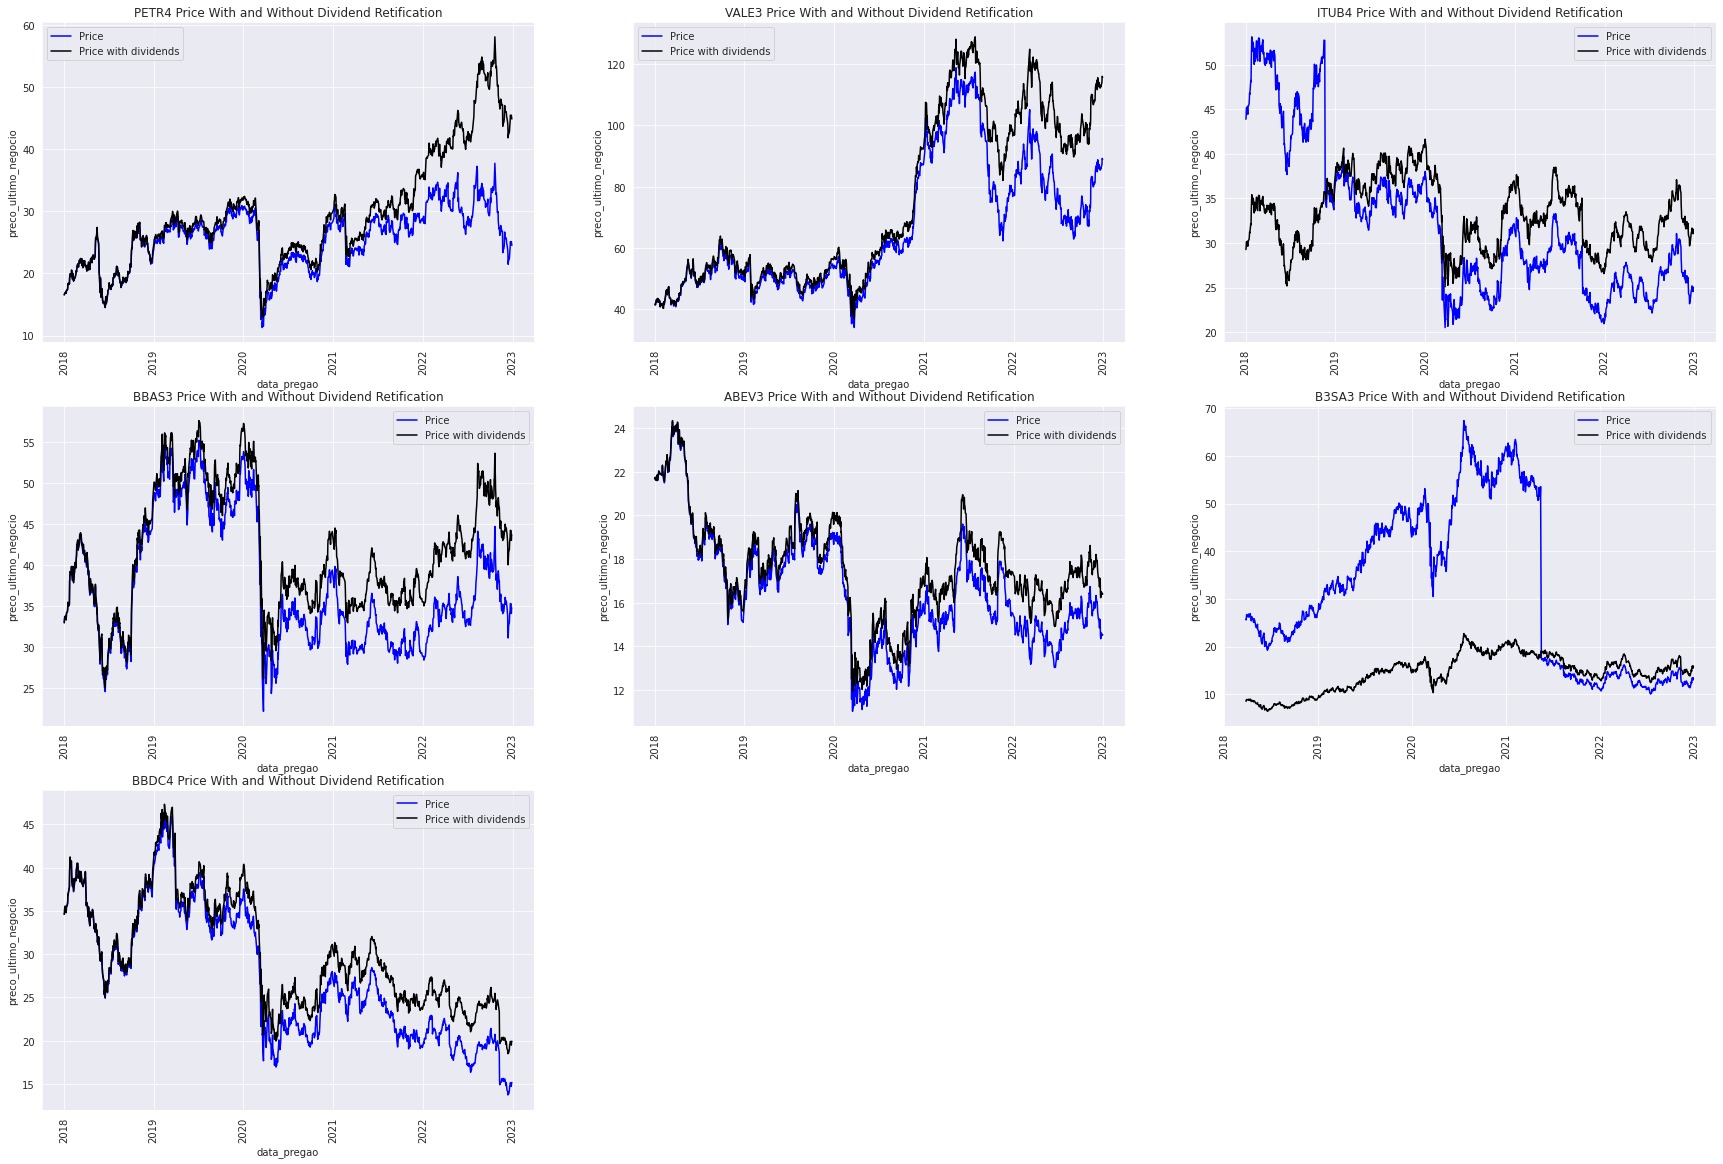

In [18]:
# @title Compare stock prices

plt.figure(figsize=(30,20))

plt.subplot(3,3,1)
plt.title("PETR4 Price With and Without Dividend Retification")
_ = sns.lineplot(
    data=petr4_stock_df_, y="preco_ultimo_negocio", x="data_pregao",
    label="Price", color='b'
)
_ = sns.lineplot(
    data=petr4_stock_df, y="preco_ultimo_negocio", x="data_pregao",
    label="Price with dividends", color='k'
)
_ = plt.xticks(rotation='vertical')

plt.subplot(3,3,2)
plt.title("VALE3 Price With and Without Dividend Retification")
_ = sns.lineplot(
    data=vale3_stock_df_, y="preco_ultimo_negocio", x="data_pregao",
    label="Price", color='b'
)
_ = sns.lineplot(
    data=vale3_stock_df, y="preco_ultimo_negocio", x="data_pregao",
    label="Price with dividends", color='k'
)
_ = plt.xticks(rotation='vertical')

plt.subplot(3,3,3)
plt.title("ITUB4 Price With and Without Dividend Retification")
_ = sns.lineplot(
    data=itub4_stock_df_, y="preco_ultimo_negocio", x="data_pregao",
    label="Price", color='b'
)
_ = sns.lineplot(
    data=itub4_stock_df, y="preco_ultimo_negocio", x="data_pregao",
    label="Price with dividends", color='k'
)
_ = plt.xticks(rotation='vertical')

plt.subplot(3,3,4)
plt.title("BBAS3 Price With and Without Dividend Retification")
_ = sns.lineplot(
    data=bbas3_stock_df_, y="preco_ultimo_negocio", x="data_pregao",
    label="Price", color='b'
)
_ = sns.lineplot(
    data=bbas3_stock_df, y="preco_ultimo_negocio", x="data_pregao",
    label="Price with dividends", color='k'
)
_ = plt.xticks(rotation='vertical')

plt.subplot(3,3,5)
plt.title("ABEV3 Price With and Without Dividend Retification")
_ = sns.lineplot(
    data=abev3_stock_df_, y="preco_ultimo_negocio", x="data_pregao",
    label="Price", color='b'
)
_ = sns.lineplot(
    data=abev3_stock_df, y="preco_ultimo_negocio", x="data_pregao",
    label="Price with dividends", color='k'
)
_ = plt.xticks(rotation='vertical')

plt.subplot(3,3,6)
plt.title("B3SA3 Price With and Without Dividend Retification")
_ = sns.lineplot(
    data=b3sa3_stock_df_, y="preco_ultimo_negocio", x="data_pregao",
    label="Price", color='b'
)
_ = sns.lineplot(
    data=b3sa3_stock_df, y="preco_ultimo_negocio", x="data_pregao",
    label="Price with dividends", color='k'
)
_ = plt.xticks(rotation='vertical')

plt.subplot(3,3,7)
plt.title("BBDC4 Price With and Without Dividend Retification")
_ = sns.lineplot(
    data=bbdc4_stock_df_, y="preco_ultimo_negocio", x="data_pregao",
    label="Price", color='b'
)
_ = sns.lineplot(
    data=bbdc4_stock_df, y="preco_ultimo_negocio", x="data_pregao",
    label="Price with dividends", color='k'
)
_ = plt.xticks(rotation='vertical')

## Save Processed Data

In [19]:
# Stocks
petr4_stock_df.to_csv(DATA_FOLDER_PATH + "processed_data/petr4_stock.csv", index=False)
vale3_stock_df.to_csv(DATA_FOLDER_PATH + "processed_data/vale3_stock.csv", index=False)
itub4_stock_df.to_csv(DATA_FOLDER_PATH + "processed_data/itub4_stock.csv", index=False)
bbas3_stock_df.to_csv(DATA_FOLDER_PATH + "processed_data/bbas3_stock.csv", index=False)
abev3_stock_df.to_csv(DATA_FOLDER_PATH + "processed_data/abev3_stock.csv", index=False)
b3sa3_stock_df.to_csv(DATA_FOLDER_PATH + "processed_data/b3sa3_stock.csv", index=False)
bbdc4_stock_df.to_csv(DATA_FOLDER_PATH + "processed_data/bbdc4_stock.csv", index=False)
bova11_stock_df.to_csv(DATA_FOLDER_PATH + "processed_data/bova11_stock.csv", index=False)

# Calls
petr4_call_df.to_csv(DATA_FOLDER_PATH + "processed_data/petr4_call.csv", index=False)
vale3_call_df.to_csv(DATA_FOLDER_PATH + "processed_data/vale3_call.csv", index=False)
itub4_call_df.to_csv(DATA_FOLDER_PATH + "processed_data/itub4_call.csv", index=False)
bbas3_call_df.to_csv(DATA_FOLDER_PATH + "processed_data/bbas3_call.csv", index=False)
abev3_call_df.to_csv(DATA_FOLDER_PATH + "processed_data/abev3_call.csv", index=False)
b3sa3_call_df.to_csv(DATA_FOLDER_PATH + "processed_data/b3sa3_call.csv", index=False)
bbdc4_call_df.to_csv(DATA_FOLDER_PATH + "processed_data/bbdc4_call.csv", index=False)
bova11_call_df.to_csv(DATA_FOLDER_PATH + "processed_data/bova11_call.csv", index=False)